In [1]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras import backend as Keras

from sklearn import metrics
from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
CAFFE_ROOT = '/home/albert/caffe/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [3]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

In [4]:
# Number of identities
P_param = 18
# Number of images per identity
K_param = 4

In [5]:
def log1p(x):
    return Keras.log(1 + Keras.exp(x))

In [6]:
def dist(x1, x2):
    return Keras.sum(Keras.abs(x1 - x2), axis=1)

In [7]:
def triplet_loss(y_true, y_pred, margin=0.5, P=P_param, K=K_param, output_dim = 128):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))

    loss = tf.Variable(1, dtype=tf.float32)

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                      embeddings[(i + 1)*K:]], 0)))
            loss += margin + hard_pos - hard_neg
    return loss

In [8]:
def pos_pair_generator(files_dict):
    while True:
        idt = np.random.choice(files_dict.keys(), 1, replace=False)[0]
        sample_choice = np.random.choice(range(len(files_dict[idt])), np.minimum(2, len(files_dict[idt])), replace=False)
        pair = [misc.imread(files_dict[idt][p]).tolist() for p in sample_choice]
        yield(np.array(pair).astype(np.uint8))

In [9]:
def neg_pair_generator(files_dict):
    while True:
        idt_choice = np.random.choice(files_dict.keys(), 2, replace=False)
        pair = []
        for idt in idt_choice:
            sample = np.random.choice(range(len(files_dict[idt])), 1, replace=False)[0]
            pair.append(misc.imread(files_dict[idt][sample]).tolist())
        yield(np.array(pair).astype(np.uint8))

In [10]:
def l2(x1, x2):
    l2 = np.sqrt(np.sum(np.power(x1 - x2, 2)))
    return l2

In [11]:
def evaluate_dist(model, generator, n_pairs=1000):
    distances = []
    for t in range(n_pairs):
        pair = generator.next()   
        predict = [model.predict(pair[i].reshape(1,128,64,3)) for i in range(2)]
        dist = distance.cosine(predict[0], predict[1])
        distances.append(dist)
    return distances

In [20]:
model = load_model('/home/albert/github/tensorflow/models/densenet_triplet_margin_3/densenet_triplet_margin_3_5000.h5', 
                   custom_objects={'triplet_loss':triplet_loss})

In [21]:
pos_generator = pos_pair_generator(test_dict)
neg_generator = neg_pair_generator(test_dict)

pos_distance = evaluate_dist(model, pos_generator)
neg_distance = evaluate_dist(model, neg_generator)

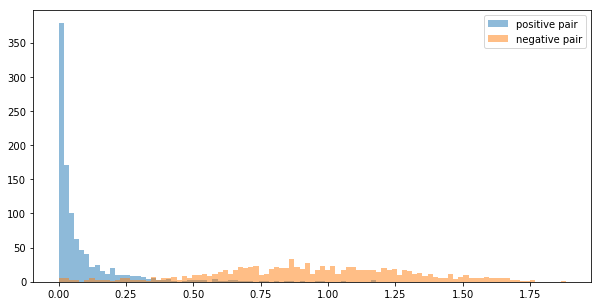

In [22]:
plt.figure(figsize=(10,5))
bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
plt.legend(loc='upper right')
plt.show()

In [23]:
precision = []
recall = []
matt_coef = []

for thresh in np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:]:
    true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
    pred_pos = [int(d < thresh) for d in pos_distance]
    pred_neg = [int(d < thresh) for d in neg_distance]
    pred = pred_pos + pred_neg

    precision.append(metrics.precision_score(true, pred))
    recall.append(metrics.recall_score(true, pred))
    matt_coef.append(metrics.matthews_corrcoef(true, pred))

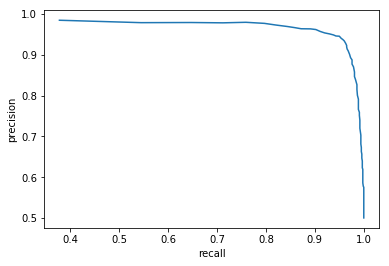

In [24]:
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')

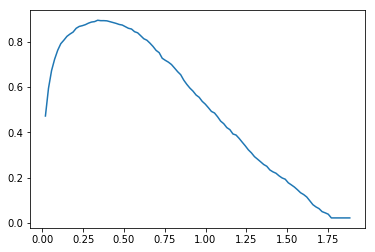

In [25]:
plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], matt_coef)

In [26]:
print np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:][np.array(matt_coef).argmax()]

0.339048831657


Training threshold: 0.143445718122 <br>
Testing threshold: 0.339048831657